<a href="https://www.kaggle.com/code/stutiiikatariaaa/lstm1?scriptVersionId=270016901" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('/kaggle/input/solargeneration/dataset.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')

2025-06-08 10:57:58.319971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749380278.501449      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749380278.557216      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Feature engineering
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek

# Select features and target
features = ['temperature', 'Ground_radiation_intensity ', 'hour']
X = df[features]
y = df['Photovoltaic_power_generation']

In [3]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)  
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [4]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

In [5]:
split_index = int(len(X_seq) * 0.8)
X_train_lstm, X_test_lstm = X_seq[:split_index], X_seq[split_index:]
y_train_lstm, y_test_lstm = y_seq[:split_index], y_seq[split_index:]

In [6]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

I0000 00:00:1749380291.155762      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749380291.156465      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


I0000 00:00:1749380295.775956      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0817 - val_loss: 0.0289
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0331 - val_loss: 0.0295
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292 - val_loss: 0.0200
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0270 - val_loss: 0.0171
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0227 - val_loss: 0.0131
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195 - val_loss: 0.0166
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0190 - val_loss: 0.0139
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - val_loss: 0.0184
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0189 - val_loss: 0.0128
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - val_loss: 0.0114
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0177 - val_loss: 0.0163
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162 - val_loss: 0.0118

In [8]:
# ----- STEP 6: PREDICT & INVERSE SCALE -----
y_pred_lstm_scaled = model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_true = scaler_y.inverse_transform(y_test_lstm)

# ----- STEP 7: EVALUATE -----
mse = mean_squared_error(y_test_true, y_pred_lstm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_true, y_pred_lstm)
r2 = r2_score(y_test_true, y_pred_lstm)

print(f"\nLSTM Test Set Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

LSTM Test Set Evaluation:
MSE: 221743.92
RMSE: 470.90
MAE: 297.87
R² Score: 0.8248


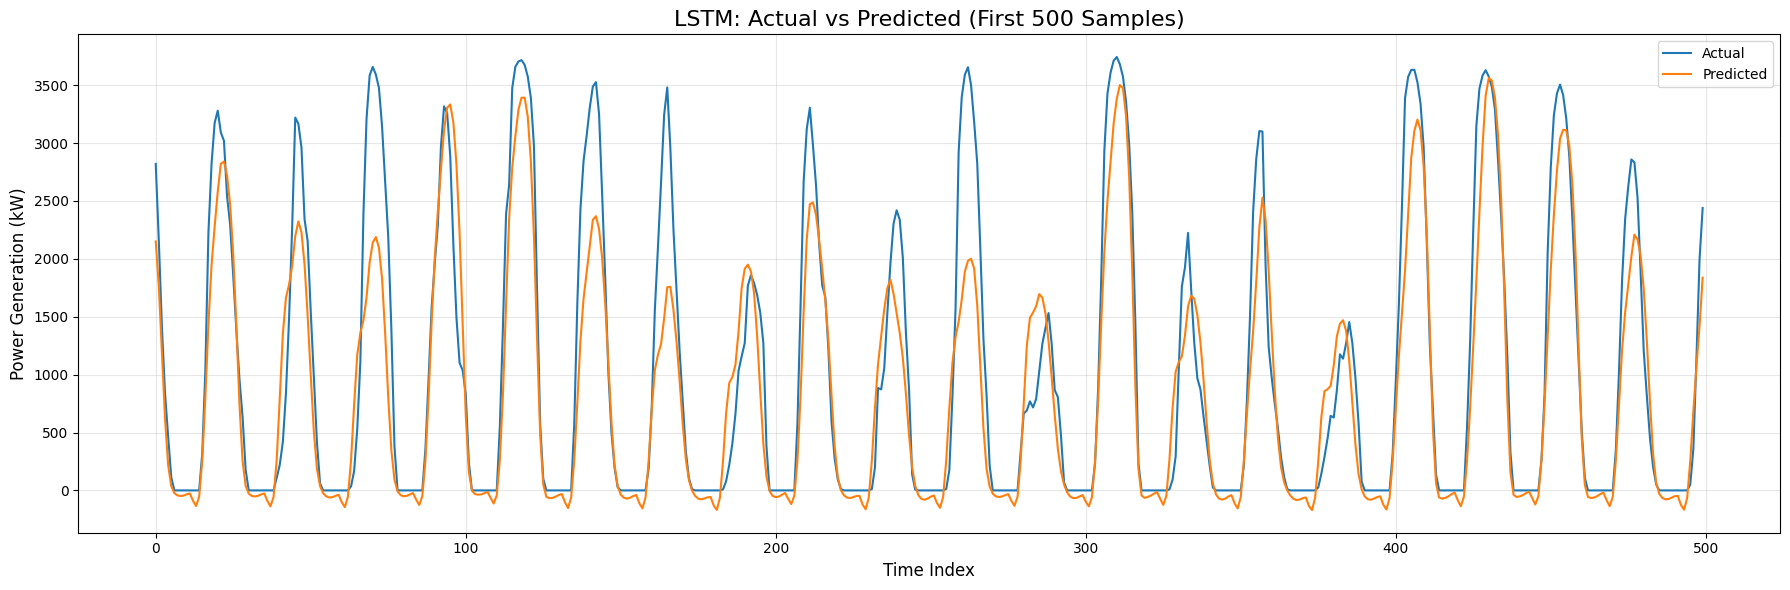

In [9]:
# ----- STEP 8: PLOT -----
plt.figure(figsize=(18, 6))
df_plot = pd.DataFrame({
    'Actual': y_test_true.flatten(),
    'Predicted': y_pred_lstm.flatten()
})
df_plot.head(500).plot(ax=plt.gca())
plt.title("LSTM: Actual vs Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
pip install keras-tuner --upgrade


Note: you may need to restart the kernel to use updated packages.


In [11]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [14]:
#X_train_lstm = X_train_lstm.values.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
#X_test_lstm = X_test_lstm.values.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units1', 32, 128, step=16),
        activation='tanh',
        return_sequences=True,
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
    ))
    model.add(LSTM(
        units=hp.Int('units2', 32, 128, step=16),
        activation='tanh'
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

In [17]:
# Set up tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=35,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='power_prediction'
)
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train_lstm, y_train_lstm,
             epochs=100,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=1)

Trial 35 Complete [00h 00m 46s]
val_loss: 0.008746657520532608

Best val_loss So Far: 0.0078093381598591805
Total elapsed time: 00h 18m 30s


In [18]:
# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Predict on test set
y_pred = best_model.predict(X_test_lstm).flatten()

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Best hyperparameters found:
units1: 32
units2: 32
lr: 0.01


In [20]:
# Evaluate
mse = mean_squared_error(y_test_lstm, y_pred_lstm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2 = r2_score(y_test_lstm, y_pred_lstm)

print("\nTuned LSTM Test Set Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")




Tuned LSTM Test Set Evaluation:
MSE: 1423245.56
RMSE: 1193.00
MAE: 793.96
R² Score: -22768414.4302


In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(18, 6))
pd.DataFrame({'Actual': y_test, 'Predicted_LSTM': y_pred}, index=y_test.index).head(500).plot(ax=plt.gca())
plt.title("Tuned LSTM: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
